# Lab 02. Простая нейронная сеть в PyTorch
Задачи этого раздела:
* создать многослойную модель
* загрузить данные
* обучить и проверить модель
* сохранить и загрузить обученную модель

Наша цель - разработать модель, способную классифицировать датасет Iris на основе четырех признаков. Это многоклассовая классификация, в которой каждый образец может принадлежать ровно ОДНОМУ из 3 классов (<em> Iris setosa </em>, <em> Iris virginica </em> или <em> Iris versicolor </em>). Сеть будет иметь 4 входных нейрона (input dimensions) и 3 выходных нейрона (scores). Наша функция потерь сравнивает целевую метку с результатом классификатора.

<div class = "alert alert-info"> <strong> ПРИМЕЧАНИЕ. </strong> Классификация на несколько классов обычно включает преобразование целевого вектора в матрицу one_hot (one-hot encoding). То есть, если 5 меток класса отображаются как <br>
<pre style = 'background-color: rgb (217,237,247)'> тензор ([0,2,1,0,1]) </pre>
то он должен кодироваться как:
<pre style = 'background-color: rgb (217,237,247)'>
тензор ([[1, 0, 0],
         [0, 0, 1],
         [0, 1, 0],
         [1, 0, 0],
         [0, 1, 0]]) </pre>
Это легко сделать с помощью <a href='https://pytorch.org/docs/stable/nn.html#one-hot'> <strong> <tt> torch.nn.functional.one_hot () </tt> </STRONG> </a>. <br>

Однако наша функция потерь <a href='https://pytorch.org/docs/stable/nn.html#crossentropyloss'> <strong> <tt> torch.nn.CrossEntropyLoss() </tt> </strong> </a> учитывает это автоматически. </div>

## Импорт

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Создаем модель
Для этого упражнения мы используем набор данных Iris. Поскольку одна прямая линия не может классифицировать три цветка, мы должны включить в нашу модель хотя бы один скрытый слой.

В следующем разделе мы будем использовать функцию <a href='https://en.wikipedia.org/wiki/Rectifier_(neural_networks)'> ReLU </a> (ReLU) <br>
$ \quad f(x) = max(0, x) $ <br>
как функцию активации. Она доступна как в виде модуля <a href='https://pytorch.org/docs/stable/nn.html#relu'> <strong> <tt> torch.nn.ReLU </tt> </strong> </a> так и просто как функциональный вызов <a href='https://pytorch.org/docs/stable/nn.html#id27'> <tt> torch.nn.functional.relu </tt > </a>

In [35]:
class Model(nn.Module):
    def __init__(self, in_features=4, h1=8, h2=9, out_features=3):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)    # input layer
        self.fc2 = nn.Linear(h1, h2)            # hidden layer
        self.out = nn.Linear(h2, out_features)  # output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [36]:
torch.manual_seed(32)
model = Model()

## Загружаем датасет

In [37]:
from sklearn.datasets import load_iris
data = load_iris()
print(data.keys())
df = pd.DataFrame(data=data['data'], columns = data['feature_names'])
df_target =  pd.DataFrame(data=data['target'], columns =['target'])
df = pd.concat([df, df_target], axis=1)
df

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


## Отрисовываем датасет


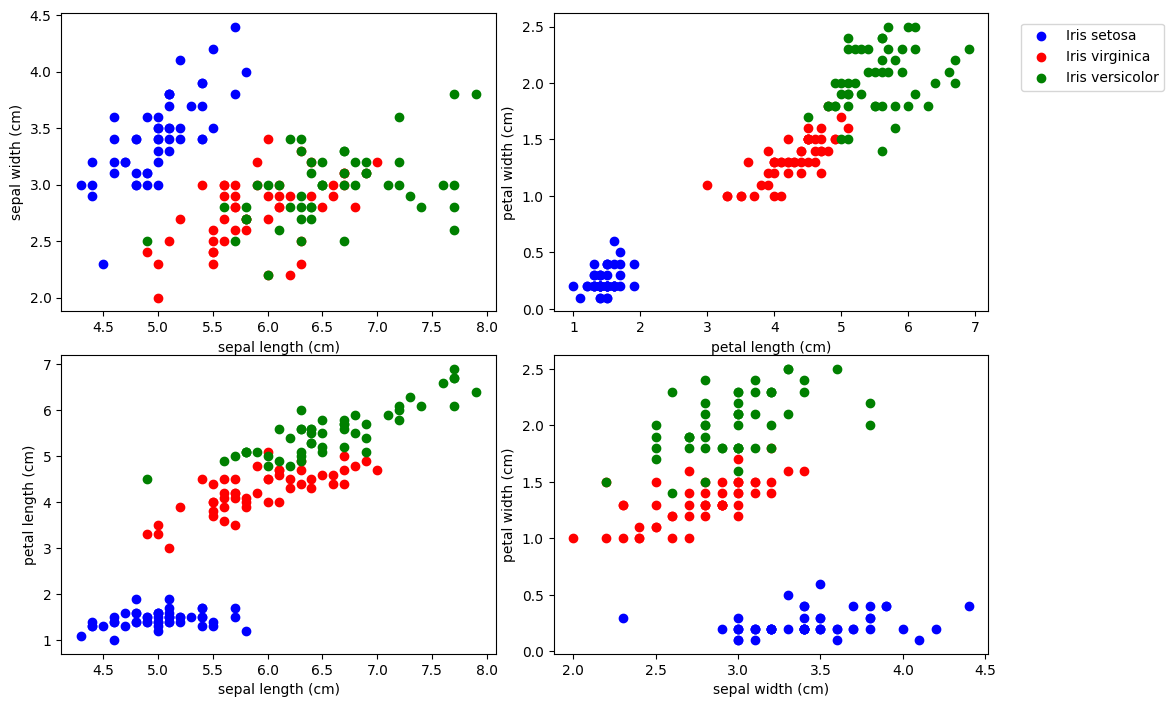

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
fig.tight_layout()

plots = [(0,1),(2,3),(0,2),(1,3)]
colors = ['b', 'r', 'g']
labels = ['Iris setosa','Iris virginica','Iris versicolor']

for i, ax in enumerate(axes.flat):
    for j in range(3):
        x = df.columns[plots[i][0]]
        y = df.columns[plots[i][1]]
        ax.scatter(df[df['target']==j][x], df[df['target']==j][y], color=colors[j])
        ax.set(xlabel=x, ylabel=y)

fig.legend(labels=labels, loc=3, bbox_to_anchor=(1.0,0.85))
plt.show()

## Выполняем сплит данных Train/Test

In [39]:
X = df.drop('target',axis=1).values
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=33)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
# y_train = F.one_hot(torch.LongTensor(y_train))  # не требуется из-за использования CrossEntropyLoss()
# y_test = F.one_hot(torch.LongTensor(y_test))
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

## Подготовка DataLoader
Нам не нужно создавать объект Dataset. Мы должны использовать инструмент DataLoader PyTorch. Несмотря на то, что наш набор данных небольшой (120 примеров), мы загрузим его в нашу модель двумя батчами. Этот метод очень полезен для больших наборов данных.

Обратите внимание, что scikit-learn уже перетасовал исходный набор данных перед подготовкой сплита.

In [40]:
trainloader = DataLoader(X_train, batch_size=60, shuffle=True)

testloader = DataLoader(X_test, batch_size=60, shuffle=False)

## Определяем функцию потерь и оптимизаторы
Мы будем использовать <a href='https://en.wikipedia.org/wiki/Cross_entropy'>Cross Entropy</a> <a href='https://pytorch.org/docs/stable/nn.html#crossentropyloss'><strong><tt>torch.nn.CrossEntropyLoss()</tt></strong></a><br>
Для оптимизатора мы будем использовать вариацию Стохастического градиентного спуска, которая называется <a href='https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam'>Adam</a> (Adaptive Moment Estimation), <a href='https://pytorch.org/docs/stable/optim.html#torch.optim.Adam'><strong><tt>torch.optim.Adam()</tt></strong></a>

In [41]:
torch.manual_seed(4)
model = Model()

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## Обучаем модель

In [43]:
from tqdm import tqdm

epochs = 100
losses = []

for _ in tqdm(range(epochs)):
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

100%|██████████| 100/100 [00:00<00:00, 1942.13it/s]


## Отрисовываем функцию потерь

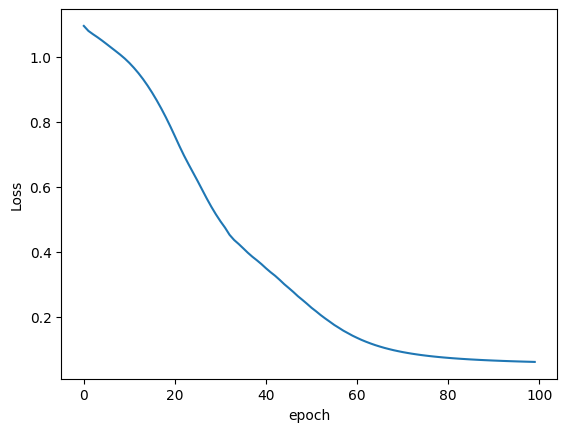

In [44]:
with torch.no_grad():
    plt.plot(range(epochs), losses)
    plt.ylabel('Loss')
    plt.xlabel('epoch')

## Тестируем модель


In [45]:

with torch.no_grad():
    y_val = model.forward(X_test)
    loss = criterion(y_val, y_test)
print(f'{loss:.8f}')

0.06236208


In [46]:
correct = 0
with torch.no_grad():
    for i,data in enumerate(X_test):
        y_val = model.forward(data)
        print(f'{i+1:2}. {str(y_val):38}  {y_test[i]}')
        if y_val.argmax().item() == y_test[i]:
            correct += 1
print(f'\n{correct} out of {len(y_test)} = {100*correct/len(y_test):.2f}% correct')

 1. tensor([-0.3405,  7.3566,  1.3707])     1
 2. tensor([0.2747, 8.1488, 0.4138])        1
 3. tensor([ 11.9818,   6.1788, -19.1899])  0
 4. tensor([-2.0217,  7.9597,  4.2340])     1
 5. tensor([-6.1397,  7.9443, 11.0864])     2
 6. tensor([-10.2711,   8.3000,  18.0008])  2
 7. tensor([ 12.0381,   6.4263, -19.2827])  0
 8. tensor([ 12.9323,   6.4755, -20.7418])  0
 9. tensor([-5.7778,  8.2352, 10.5033])     2
10. tensor([-7.8917,  8.6034, 14.0677])     2
11. tensor([-8.7110,  8.5980, 15.4298])     2
12. tensor([ 11.6191,   5.8112, -18.6104])  0
13. tensor([-8.1081,  8.2234, 14.3879])     2
14. tensor([-2.0836,  7.7684,  4.3107])     1
15. tensor([-6.0867,  8.3830, 11.0509])     2
16. tensor([0.1330, 7.8598, 0.6288])        1
17. tensor([-4.0930,  7.7140,  7.6592])     2
18. tensor([ 13.1338,   6.5848, -21.0678])  0
19. tensor([-1.5696,  8.0146,  3.4673])     1
20. tensor([-6.2900,  8.9642, 11.4163])     2
21. tensor([ 12.3687,   6.2517, -19.8166])  0
22. tensor([ 13.8037,   7.0790, -2

## Сохранение модели

Существует два основных способа сохранить модель.<br>

Первый сохраняет / загружает state_dict (обученные параметры) модели, но не класс модели. Синтаксис следующий:

Сохранить: torch.save (model.state_dict(), PATH)

Загрузить:

model  = TheModelClass()

model.load_state_dict(torch.load (PATH))

model.eval()

Второй способ сохраняет всю модель, включая ее класс и параметры, в виде файла.

Сохранить: torch.save (model, PATH)

Load:

model = torch.load (PATH))
model.eval ()
       
В любом из этих методов вы должны вызвать model.eval(), чтобы установить dropout и batch normalization в режиме оценки перед запуском вывода. Невыполнение этого приведет к некорректным результатам.

См. также
https://pytorch.org/tutorials/beginner/saving_loading_models.html

### Сохраняем

In [47]:
torch.save(model.state_dict(), '../../data/IrisDatasetModel.pt')

### Загружаем


In [48]:
new_model = Model()
new_model.load_state_dict(torch.load('../../data/IrisDatasetModel.pt'))
new_model.eval()

Model(
  (fc1): Linear(in_features=4, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=9, bias=True)
  (out): Linear(in_features=9, out_features=3, bias=True)
)

In [49]:
with torch.no_grad():
    y_val = new_model.forward(X_test)
    loss = criterion(y_val, y_test)
print(f'{loss:.8f}')

0.06236208


## Применить модель для классификации новых данных

In [50]:
mystery_iris = torch.tensor([5.6,3.7,2.2,0.5])

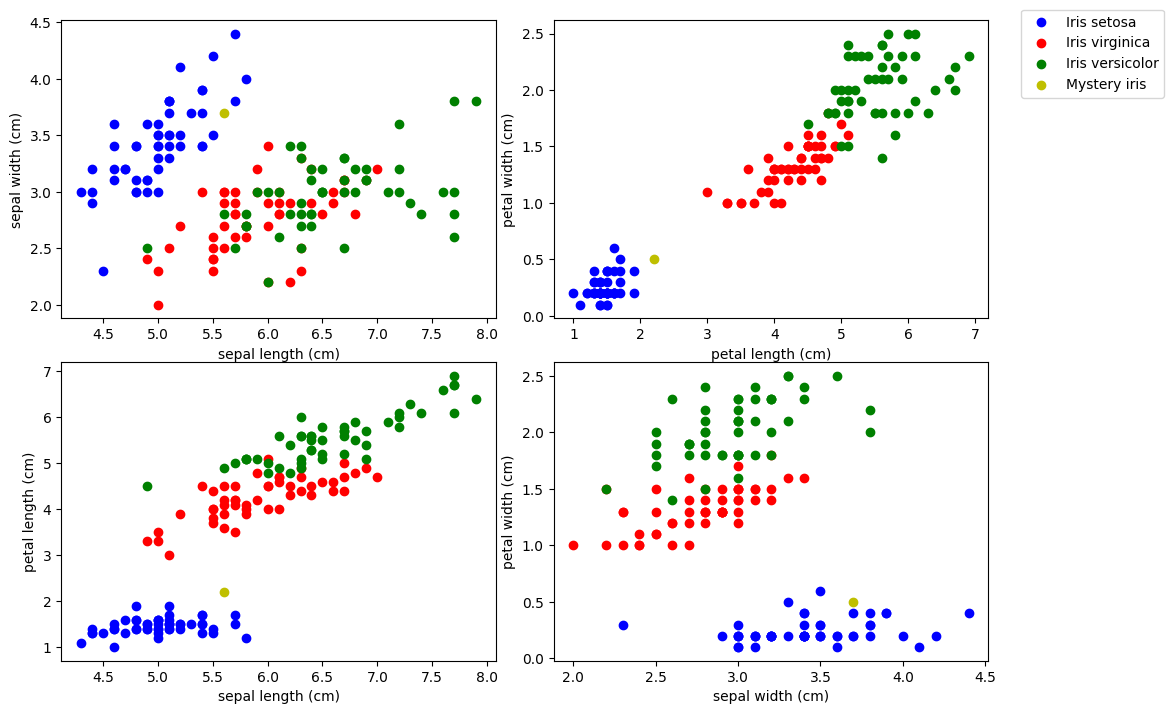

In [51]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
fig.tight_layout()

plots = [(0,1),(2,3),(0,2),(1,3)]
colors = ['b', 'r', 'g']
labels = ['Iris setosa','Iris virginica','Iris versicolor','Mystery iris']

for i, ax in enumerate(axes.flat):
    for j in range(3):
        x = df.columns[plots[i][0]]
        y = df.columns[plots[i][1]]
        ax.scatter(df[df['target']==j][x], df[df['target']==j][y], color=colors[j])
        ax.set(xlabel=x, ylabel=y)

    # Add a plot for our mystery iris:
    ax.scatter(mystery_iris[plots[i][0]],mystery_iris[plots[i][1]], color='y')

fig.legend(labels=labels, loc=3, bbox_to_anchor=(1.0,0.85))
plt.show()

Выполняем вывод

In [52]:
with torch.no_grad():
    print(new_model(mystery_iris))
    print()
    print(labels[new_model(mystery_iris).argmax()])

tensor([ 12.1977,   7.1240, -19.5230])

Iris setosa
